In [188]:
%matplotlib inline
import math
import scipy
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

### Data Preparation

In [128]:
# Read data
df = pd.read_csv('../Data/world_happiness_report_2/2017.csv')
df.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [129]:
# Clean data
df = df[['Country', 'Happiness.Score', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.']]

df = df.rename(index=str, columns={'Happiness.Score': 'happiness_score',
                              'Economy..GDP.per.Capita.': 'gdp_per_capita',
                              'Health..Life.Expectancy.': 'life_expectancy',
                              'Trust..Government.Corruption.': 'trust_in_government',
                              'Family': 'family',
                              'Freedom': 'freedom',
                              'Generosity': 'generosity',
                              'Country': 'country'})

df.head()

,country,happiness_score,gdp_per_capita,family,life_expectancy,freedom,generosity,trust_in_government
0,Norway,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964
1,Denmark,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770
2,Iceland,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527
3,Switzerland,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007
4,Finland,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612


In [71]:
# Check for missing values
df.isnull().values.any()

False

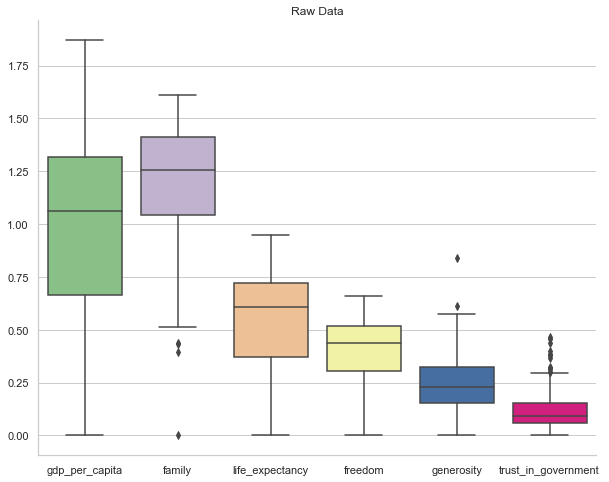

In [130]:
# Plot to see outliers
f, ax = plt.subplots(figsize=(10, 8))
sns.set(style='whitegrid')
sns.despine()

sns.boxplot(data=df[['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']], palette='Accent')
plt.title('Raw Data')
plt.show()

Although there is some overlap, I think I might still need to normalize the scores before we start delving into the data to check for things like correlation.

In [145]:
# Normalize data
# Select columns to be normalized
raw_data = df[['happiness_score', 'gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']]

# Normalize
norm_data = preprocessing.normalize(raw_data)

# Store in new dataframe
norm_df = pd.DataFrame(norm_data, columns=['happiness_score', 'gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government'])
norm_df.head()


,happiness_score,gdp_per_capita,family,life_expectancy,freedom,generosity,trust_in_government
0,0.949269,0.203590,0.193144,0.100338,0.080030,0.045595,0.039795
1,0.951536,0.187522,0.196218,0.100260,0.079190,0.044943,0.050698
2,0.949690,0.187386,0.203831,0.105493,0.079372,0.060183,0.019430
3,0.949824,0.198353,0.192260,0.108764,0.078591,0.036826,0.046516
4,0.952525,0.184099,0.196428,0.103192,0.078808,0.031307,0.048795


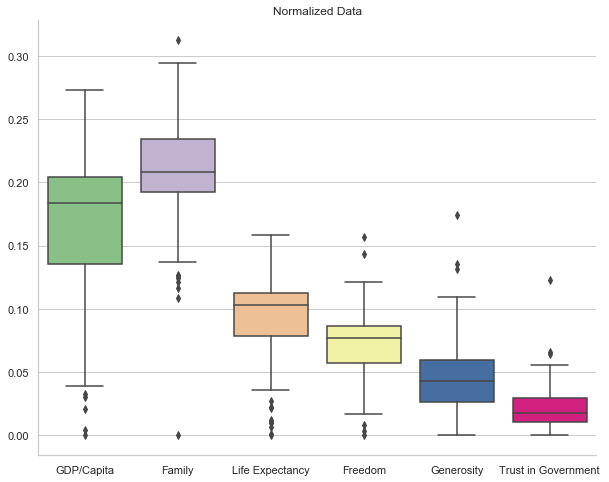

In [146]:
# Let's see the normalized data
f, ax = plt.subplots(figsize=(10, 8))
sns.despine()
sns.set(style='whitegrid')

# Plot the independent variable columns
data = normalized_df[['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']]

sns.boxplot(data=data, palette='Accent')
plt.title('Normalized Data')
plt.xticks([0, 1, 2, 3, 4, 5], ['GDP/Capita', 'Family', 'Life Expectancy', 'Freedom', 'Generosity', 'Trust in Government'])
plt.show()

In [147]:
# Just for the exercise, let's try standardizing the data
stand_data = preprocessing.scale(raw_data)

# Store in new dataframe
stand_df = pd.DataFrame(stand_data, columns=['happiness_score', 'gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government'])
stand_df.head()


,happiness_score,gdp_per_capita,family,life_expectancy,freedom,generosity,trust_in_government
0,1.935996,1.506188,1.203577,1.038167,1.515836,0.856964,1.903084
1,1.922693,1.186518,1.265036,1.020812,1.452859,0.806856,2.739998
2,1.906730,1.182345,1.472669,1.194259,1.460590,1.702013,0.300066
3,1.897861,1.383442,1.145561,1.298272,1.413155,0.325028,2.406809
4,1.875689,1.093985,1.227057,1.091026,1.398978,-0.010426,2.560800


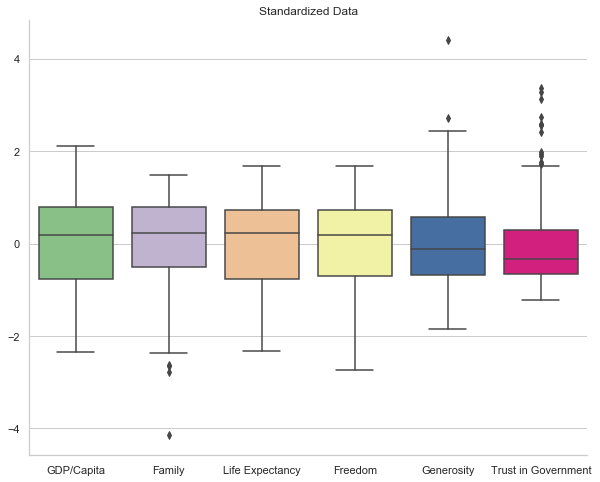

In [148]:
# Plot standardized data
f, ax = plt.subplots(figsize=(10, 8))
sns.despine()
sns.set(style='whitegrid')

data = stand_df[['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']]

sns.boxplot(data=data, palette='Accent')
plt.title('Standardized Data')
plt.xticks([0, 1, 2, 3, 4, 5], ['GDP/Capita', 'Family', 'Life Expectancy', 'Freedom', 'Generosity', 'Trust in Government'])
plt.show()

Standardized data looks cleaner with less outliers, so let's move ahead with the X_stand and calculate the correlation between the independent variables.

In [149]:
# Correlation Matrix
X = raw_data[['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']]

corr_mat = X.corr()
display(corr_mat)

,gdp_per_capita,family,life_expectancy,freedom,generosity,trust_in_government
gdp_per_capita,1.000000,0.688296,0.843077,0.369873,-0.019011,0.350944
family,0.688296,1.000000,0.612080,0.424966,0.051693,0.231841
life_expectancy,0.843077,0.612080,1.000000,0.349827,0.063191,0.279752
freedom,0.369873,0.424966,0.349827,1.000000,0.316083,0.499183
generosity,-0.019011,0.051693,0.063191,0.316083,1.000000,0.294159
trust_in_government,0.350944,0.231841,0.279752,0.499183,0.294159,1.000000


It doesn't look like we have to worry too much about redundancy in our data. One interesting correlation is between GDP/Capita and Generosity. There is a very slight negative correlation, meaning that generosity levels stay flat or even decreases with an increase in GDP. Draw whatever conclusion you might from that, and let's move on.

### OLS Regression Model

In [150]:
# Build OLS regression model
X = raw_data[['gdp_per_capita', 'family', 'life_expectancy','freedom', 'generosity', 'trust_in_government']]
Y = raw_data['happiness_score']
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# QUESTION: WHAT IS THE CONVENTION WITH x, y, X and Y?

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [159]:
# R2 score, Intercept, and coefficients
r2 = regr.score(X, Y)
intercept = regr.intercept_
coef = regr.coef_

stats = {'R2': r2,
         'α': intercept,
         'β1': coef[0],
         'β2': coef[1],
         'β3': coef[2],
         'β4': coef[3],
         'β5': coef[4],
         'β6': coef[5]}

stats_df = pd.DataFrame(stats, index=['stats'])
display(stats_df)

,R2,α,β1,β2,β3,β4,β5,β6
stats,0.812425,1.743029,0.784433,1.117771,1.28888,1.475715,0.380718,0.826607


In [156]:
# Try the same with normalized data
X_norm = norm_df[['gdp_per_capita', 'family', 'life_expectancy','freedom', 'generosity', 'trust_in_government']]
Y_norm = norm_df['happiness_score']
regr_norm = linear_model.LinearRegression()
regr_norm.fit(X_norm, Y_norm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [166]:
# Calculate R2, intercept and coefficients
r2_norm = regr_norm.score(X_norm, Y_norm)
intercept_norm = regr_norm.intercept_
coef_norm = regr_norm.coef_

stats_norm = {'R2': r2_norm,
              'α': intercept_norm,
              'β1': coef_norm[0],
              'β2': coef_norm[1],
              'β3': coef_norm[2],
              'β4': coef_norm[3],
              'β5': coef_norm[4],
              'β6': coef_norm[5]}

stats_norm_df = pd.DataFrame(stats_norm, index=['stats_norm'])
stats_df = stats_df.append(stats_norm_df)
display(stats_df)

,R2,α,β1,β2,β3,β4,β5,β6
stats,0.812425,1.743029,0.784433,1.117771,1.288880,1.475715,0.380718,0.826607
stats_norm,0.914119,1.033214,-0.154231,-0.195923,-0.062796,-0.062107,-0.086359,-0.063272


In [167]:
# Try the same with standardized data just for kicks
X_stand = stand_df[['gdp_per_capita', 'family', 'life_expectancy','freedom', 'generosity', 'trust_in_government']]
Y_stand = stand_df['happiness_score']
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand, Y_stand)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [168]:
# Calculate R2, intercept and coefficients
r2_stand = regr_stand.score(X_stand, Y_stand)
intercept_stand = regr_stand.intercept_
coef_stand = regr_stand.coef_

stats_stand = {'R2': r2_stand,
              'α': intercept_stand,
              'β1': coef_stand[0],
              'β2': coef_stand[1],
              'β3': coef_stand[2],
              'β4': coef_stand[3],
              'β5': coef_stand[4],
              'β6': coef_stand[5]}

stats_stand_df = pd.DataFrame(stats_stand, index=['stats_stand'])
stats_df = stats_df.append(stats_stand_df)
display(stats_df)

,R2,α,β1,β2,β3,β4,β5,β6
stats,0.812425,1.743029e+00,0.784433,1.117771,1.288880,1.475715,0.380718,0.826607
stats_norm,0.914119,1.033214e+00,-0.154231,-0.195923,-0.062796,-0.062107,-0.086359,-0.063272
stats_stand,0.812425,-1.339671e-16,0.291792,0.283845,0.270112,0.195675,0.045361,0.074285


In [176]:
# Check p-values to see if any of the variables can be excluded without hurting the R2 score.
# We'll use statsmodels for this
formula = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom+generosity+trust_in_government'
formula_norm = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom+generosity+trust_in_government'
formula_stand = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom+generosity+trust_in_government'

lm = smf.ols(formula=formula, data=df).fit()
lm_norm = smf.ols(formula=formula_norm, data=norm_df).fit()
lm_stand = smf.ols(formula=formula_stand, data=stand_df).fit()

# Check for consistency
print('Raw:\n', lm.params)
print('\nNormalized:\n', lm_norm.params)
print('\nStandardized:\n', lm_stand.params)

Raw:
 Intercept              1.743029
gdp_per_capita         0.784433
family                 1.117771
life_expectancy        1.288880
freedom                1.475715
generosity             0.380718
trust_in_government    0.826607
dtype: float64

Normalized:
 Intercept              1.033214
gdp_per_capita        -0.154231
family                -0.195923
life_expectancy       -0.062796
freedom               -0.062107
generosity            -0.086359
trust_in_government   -0.063272
dtype: float64

Standardized:
 Intercept             -1.942890e-16
gdp_per_capita         2.917920e-01
family                 2.838452e-01
life_expectancy        2.701116e-01
freedom                1.956749e-01
generosity             4.536064e-02
trust_in_government    7.428497e-02
dtype: float64


In [177]:
# Looking good. Now let's check p-values
print('Raw:\n',lm.pvalues)
print('\nNormalized:\n', lm_norm.pvalues)
print('\nStandardized:\n', lm_stand.pvalues)

Raw:
 Intercept              1.697316e-16
gdp_per_capita         1.848734e-04
family                 1.399572e-07
life_expectancy        9.648650e-05
freedom                2.980926e-05
generosity             2.495240e-01
trust_in_government    8.997508e-02
dtype: float64

Normalized:
 Intercept              2.821516e-229
gdp_per_capita          5.518008e-41
family                  1.421564e-54
life_expectancy         2.327492e-06
freedom                 5.614898e-06
generosity              1.101476e-09
trust_in_government     2.808367e-03
dtype: float64

Standardized:
 Intercept              1.000000e+00
gdp_per_capita         1.848734e-04
family                 1.399572e-07
life_expectancy        9.648650e-05
freedom                2.980926e-05
generosity             2.495240e-01
trust_in_government    8.997508e-02
dtype: float64


We have two variables whose p-scores are higher than 0.05: generosity at 0.25 and trust in government at 0.09. So let's reduce our feature set and retry. We will leave the features as is for normalized dataset as its p-values are all less than 0.05.

In [178]:
formula = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom'
formula_norm = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom+generosity+trust_in_government'
formula_stand = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom'

lm = smf.ols(formula=formula, data=df).fit()
lm_norm = smf.ols(formula=formula_norm, data=norm_df).fit()
lm_stand = smf.ols(formula=formula_stand, data=stand_df).fit()

print('Raw: ', lm.rsquared)
print('Normalized: ', lm_norm.rsquared)
print('Standardized: ', lm_stand.rsquared)

Raw:  0.8056325565086679
Normalized:  0.9141194116210707
Standardized:  0.8056325565086679


#### Raw Data

In [179]:
# New and improved model
X = raw_data[['gdp_per_capita', 'family', 'life_expectancy','freedom']]
Y = raw_data['happiness_score']
regr = linear_model.LinearRegression()
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [182]:
r2 = regr.score(X, Y)
intercept = regr.intercept_
coef = regr.coef_

stats = {'R2': r2,
         'α': intercept,
         'β1': coef[0],
         'β2': coef[1],
         'β3': coef[2],
         'β4': coef[3]}

pd.DataFrame(stats, index=['raw'])

,R2,α,β1,β2,β3,β4
raw,0.805633,1.799151,0.817858,1.068498,1.302935,1.861153


In [209]:
# Cross-validate the model
cvs = cross_val_score(regr, X, Y, cv=10)
print(cvs.mean())

-23.40187908998023


#### Normalized Data

In [208]:
regr_norm = linear_model.LinearRegression()
regr_norm.fit(X_norm, Y_norm)
cvs_norm = cross_val_score(regr_norm, X_norm, Y_norm, cv=10)
print(cvs_norm.mean())

0.7917790738546312


#### Standardized Data

In [210]:
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand, Y_stand)
cvs_stand = cross_val_score(regr_stand, X_stand, Y_stand, cv=10)
print(cvs_stand.mean())

-22.798931287049662


I think I will stick with the normalized data from here on out.

### KNN Regression

In [197]:
# Unweighted
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X_norm, Y_norm)

score = cross_val_score(knn, X_norm, Y_norm, cv=10)
print(score)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std()*2))

[0.56035226 0.8969097  0.86516586 0.92004591 0.8163999  0.87570927
 0.83247504 0.760546   0.81022072 0.76626561]
Unweighted Accuracy: 0.81 (+/- 0.19)


In [207]:
# Weighted
knn_w = neighbors.KNeighborsRegressor(n_neighbors=7, weights='distance')
knn_w.fit(X_norm, Y_norm)

score_w = cross_val_score(knn_w, X_norm, Y_norm, cv=10)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std()*2))

[0.59947529 0.86592499 0.85572611 0.90652785 0.79977107 0.8886901
 0.80690807 0.78077922 0.80747877 0.74578426]
Weighted Accuracy: 0.81 (+/- 0.17)
